In [1]:
import torch

from torch import nn

import torch.nn.functional as F

from torchinfo import summary

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

from torch.optim import AdamW

from torchvision.transforms import Compose, RandomVerticalFlip, ToTensor, Resize
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

import numpy as np
import matplotlib.pyplot as plt

import random

from tqdm import tqdm

import math

from sklearn.metrics import recall_score

In [2]:
BATCH_SIZE = 16
IMG_SIZE = 128

# Data processing

In [3]:
transform_train = Compose([
    Resize([IMG_SIZE, IMG_SIZE]),
    RandomVerticalFlip(0.2),
    ToTensor()
])

transform_test = Compose([
    Resize([IMG_SIZE, IMG_SIZE]),
    RandomVerticalFlip(0.2),
    ToTensor()
])

In [4]:
train_ds = ImageFolder('data/train/', transform=transform_train)
test_ds = ImageFolder('data/test/', transform=transform_test)

In [5]:
np.random.shuffle(test_ds.samples)

In [6]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, drop_last=True)

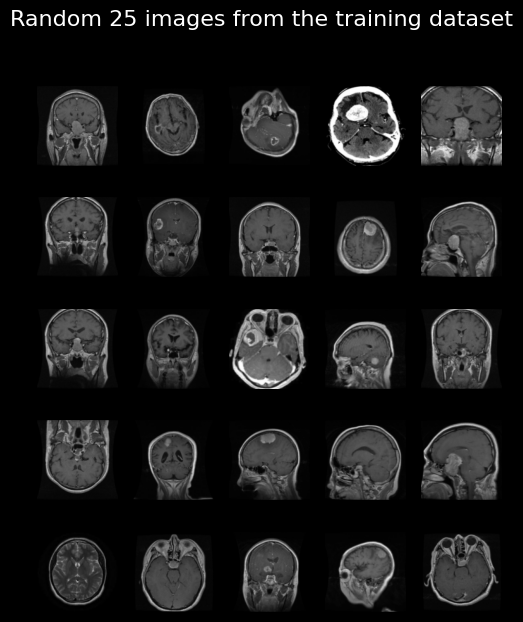

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(6, 7))

for i in range(5):
    for j in range(5):
        image_index = random.randrange(len(train_ds))

        axs[i, j].imshow(train_ds[image_index][0].permute((1, 2, 0)))

        axs[i, j].axis(False)

fig.suptitle(f"Random 25 images from the training dataset", fontsize=16, color="white")
fig.set_facecolor(color='black')
plt.show()

In [8]:
samples = []
ind = []

for i in range(len(train_ds)):
    if train_ds[i][1] not in ind:
        samples.append(train_ds[i][0])
        ind.append(train_ds[i][1])
    
    if len(ind) == 4: break

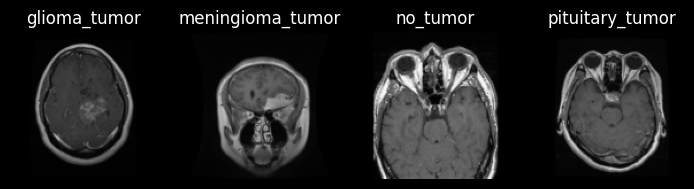

In [9]:
plt.style.use("dark_background")
plt.figure(figsize=(10, 7))

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(to_pil_image(samples[i]))
    plt.title(list(train_ds.class_to_idx.keys())[i])
    plt.axis(False)

plt.subplots_adjust(bottom=0.1, right=0.8, top=1.05)
plt.show()

# Model architecture

In [10]:
IMG_CHANNELS = 3
PATCH_SIZE = 16

EMBEDDING_DIM = IMG_CHANNELS * PATCH_SIZE**2
NUM_PATCHES = IMG_SIZE**2 / PATCH_SIZE**2

In [11]:
NUM_PATCHES

64.0

In [12]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, batch_size):
        super().__init__()
        
        self.patch_conv = nn.Conv2d(in_channels=IMG_CHANNELS, out_channels=EMBEDDING_DIM, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)
        self.flatten = nn.Flatten(end_dim=2)
        self.class_token_emb = nn.Parameter(torch.rand((batch_size, 1, EMBEDDING_DIM), requires_grad=True))
        
        self.pos_emb = nn.Parameter(torch.rand((batch_size, 1, EMBEDDING_DIM), requires_grad=True))


    def forward(self, x):
        x = self.patch_conv(x).permute((0, 2, 3, 1)) # [batch_size, NUM_PATCHES**0.5, NUM_PATCHES**0.5, EMBEDDING_DIM]
        x = self.flatten(x) # [batch_size, NUM_PATCHES, EMBEDDING_DIM]
        x = torch.cat([self.class_token_emb, x], dim=1) # [batch_size, NUM_PATCHES + 1, EMBEDDING_DIM]
        x = x + self.pos_emb

        return x

In [13]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, embedding_dims = 768, 
               num_heads = 12,
               attn_dropout = 0.0 
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [14]:
class MLPBlock(nn.Module):
    def __init__(self, emb_dim, mlp_dim, mlp_dropout=0.2):
        super().__init__()

        self.ln = nn.LayerNorm(emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(mlp_dropout),
            nn.Linear(mlp_dim, emb_dim),
            nn.Dropout(mlp_dropout),
        )

    def forward(self, x):
        x = self.ln(x)
        x = self.mlp(x)

        return x

In [15]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims, num_heads, attn_dropout)

    self.mlp_block = MLPBlock(embedding_dims, mlp_size, mlp_dropout = mlp_dropout)

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x


In [16]:
class ViT(nn.Module):
  def __init__(self,
               embedding_dims = 768,
               num_transformer_layers = 12,
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 4):
    super().__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(BATCH_SIZE)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

# Model training

In [17]:
device = torch.device('cuda')

In [18]:
class NetTraining:
    def __init__(self, model, train_dl, criterion, test_dl=None):
        self.model = model

        self.dataloaders = {
            "Train" : train_dl
        }

        self.results = {
            "Train" : {
                "loss" : [],
                "avg_epoch_loss" : [],
                "epoch_recall" : []     
            },
            "model_state" : model.state_dict()
        }

        self.phases = ["Train"]

        if test_dl is not None:
            self.dataloaders["Test"] = test_dl
            self.results["Test"] = {
                "loss" : [],
                "avg_epoch_loss" : [],
                "epoch_recall" : []
            }
            self.phases.append("Test")

        self.num_epochs_train = 0
        self.criterion = criterion
    
    def get_gradient_norm(self):
        total_norm = 0
        parameters = [p for p in self.model.parameters() if p.grad is not None and p.requires_grad]
        for p in parameters:
            param_norm = p.grad.detach().data.norm(2)
            total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5

        return total_norm
    

    def get_recall(self, logits, y_true):
        y_pred = torch.softmax(logits, dim=1).argmax(dim=1)

        return recall_score(y_true.cpu(), y_pred.cpu(), average='micro')
    

    def train(self, optimizer, epochs, scheduler=None):
        for epoch in range(epochs):
            self.num_epochs_train += 1
            
            for phase in self.phases:
                dataloader = self.dataloaders[phase]
                epoch_loss = 0
                epoch_recall = 0

                with tqdm(dataloader, unit="batch") as tepoch:
                    if phase == "Train":
                        self.model.train()
                    else:
                        self.model.eval()

                    for step, batch in enumerate(tepoch):
                        tepoch.set_description(f"Epoch {self.num_epochs_train} Phase: {phase}")
                        
                        X_tensor = batch[0].to(device=device, dtype=torch.float32)
                        labels = batch[1].to(device=device)

                        y_true = F.one_hot(labels, 4).to(torch.float32)

                        logits = self.model(X_tensor).squeeze()

                        loss = self.criterion(logits, y_true)
                        recall = self.get_recall(logits, labels)

                        epoch_loss += loss.item()
                        epoch_recall += recall

                        self.results[phase]["loss"].append(loss.item())
                        
                        if phase == "Train":
                            gradient_norm = self.get_gradient_norm()
                            optimizer.zero_grad()
                            loss.backward(retain_graph=True)
                            optimizer.step()

                            if scheduler is not None:
                                scheduler.step(loss)

                            tepoch.set_postfix(recall=epoch_recall/(step+1), avg_loss=epoch_loss/(step+1), gradient_norm=gradient_norm)
                        
                        else:
                            tepoch.set_postfix(recall=epoch_recall/(step+1), avg_loss=epoch_loss/(step+1))
                        
                    self.results[phase]["avg_epoch_loss"].append(epoch_loss/(step+1))
                    self.results[phase]["epoch_recall"].append(epoch_recall/(step+1))

        self.results["model_state"] = self.model.state_dict()


    def plot_results(self, metrics_to_plot=["avg_epoch_loss"]):
        nrows = len(self.phases)
        ncols = len(metrics_to_plot)

        _, ax = plt.subplots(nrows, ncols, figsize=(14, 4))
        for ph_i, phase in enumerate(self.phases):
            for m_i, metric in enumerate(metrics_to_plot):
                if len(self.phases) == 1:
                    ax[m_i].plot(self.results[phase][metric])
                    ax[m_i].set_title(f"{phase} {metric}")

                elif len(metrics_to_plot) == 1:
                    ax[ph_i].plot(self.results[phase][metric])
                    ax[ph_i].set_title(f"{phase} {metric}")
                else:
                    ax[ph_i, m_i].plot(self.results[phase][metric])
                    ax[ph_i, m_i].set_title(f"{phase} {metric}")
                
        plt.subplots_adjust(bottom=0.2, right=0.8, top=1.7)
        plt.show()
    

In [34]:
model = ViT(num_transformer_layers=12, mlp_dropout=0.2, num_heads=12, attn_dropout=0.1).to(device)
criterion = nn.BCEWithLogitsLoss()

In [35]:
net_train = NetTraining(model, train_dl, criterion, test_dl)

In [39]:
optimizer = AdamW(model.parameters(), lr=1e-5)

In [45]:
net_train.train(optimizer, 1)

Epoch 169 Phase: Test: 100%|██████████| 24/24 [00:00<00:00, 29.10batch/s, avg_loss=1.07, recall=0.695] 


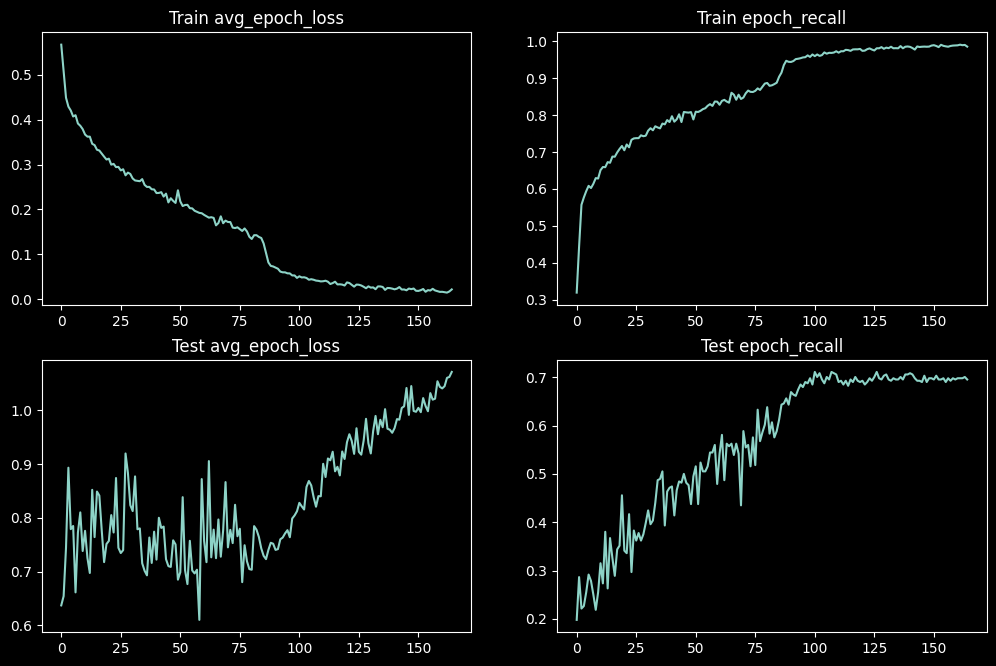

In [46]:
net_train.plot_results(metrics_to_plot=["avg_epoch_loss", "epoch_recall"])

In [42]:
torch.save(net_train.results['model_state'], 'rec_708.pth')